### **Table of Contents**
    
* [Error Handling](#error-handling)
* [Exploration and Cleaning](#exploration-and-cleaning)
  * [EDA Function](#eda-function)
  * [K Count](#k-count)
  * [HUD](#hud)
* [Keep this file in your project](#keep-this-file-in-your-project)

In [50]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from highlight_text import ax_text
from cycler import cycler
import numpy as np

# Error Handling

In [25]:
def safe_read_excel(filepath, **kwargs):
    """Read Excel safely and handle both single- and multi-sheet files."""

    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return {}

    try:
        df = pd.read_excel(filepath, **kwargs)
        if isinstance(df, dict):
            print(f"Loaded {len(df)} sheets from {os.path.basename(filepath)}")
        else:
            print(f"Loaded {os.path.basename(filepath)} — shape {df.shape}")
        return df
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return {}

# Exploration and Cleaning

## EDA Function

In [26]:
def basic_eda(df: pd.DataFrame, show_head: bool = True, show_tail: bool = True, show_info: bool = True) -> None:
    """
    Prints a quick summary of a DataFrame, including shape, column names, data types,
    missing values, and optional previews of the data.

    Args:
        df: The pandas DataFrame to summarize.
        show_head: Whether to display df.head(). Default is True.
        show_tail: Whether to display df.tail(). Default is True.
        show_info: Whether to display df.info(). Default is True.

    Returns:
        None. Creates a printed summary.
    """

    print("DataFrame Shape:", df.shape)
    print("\n Column Names:")
    print(df.columns.tolist())

    print("\n Data Types:")
    print(df.dtypes)

    if show_info:
        print("\n DataFrame Info:")
        df.info()

    print("\n Null Values (%):")
    nulls = df.isnull().mean() * 100 
    print(nulls[nulls > 0].round(2).sort_values(ascending=False))

    if show_head:
        print("\n Preview (Head):")
        print(df.head())

    if show_tail:
        print("\n Preview (Tail):")
        print(df.tail())

## K Count

Importing K count data (starts on line 2) and calling EDA function

In [27]:
kcount_df = safe_read_excel("../ashley/data/k_count.xlsx", header=2)

basic_eda(kcount_df)

Loaded k_count.xlsx — shape (133, 15)
DataFrame Shape: (133, 15)

 Column Names:
['County', 'KY Balance of State CoC Region', 'KY Area Development District (Balance of State Coordinated Entry Local Prioritization Community)', 'Total   Homeless ', 'Population Estimates 2024* (most recent available in 2025)', 'Percentage of Population', 'Total Number of persons', 'Total Number of persons.1', 'Total Number of persons.2', 'Total Number of Veterans', 'Total Number of Chronically Homeless Persons', 'Adults with Serious Mental Illness (self-reported)', 'Adults with a Substance Use Disorder (self-reported)', 'Adults with HIV/AIDS (self-reported)', 'Adults whose current episode of homelessness caused by domestic violence (self-reported)']

 Data Types:
County                                                                                               object
KY Balance of State CoC Region                                                                       object
KY Area Development District (

Removing rows without a county name

In [28]:
kcount_df = kcount_df[kcount_df['County'].notna()].copy()

Remove whitespace and special characters from column names

In [29]:
kcount_df.columns = (
    kcount_df.columns
    .str.strip()                      
    .str.replace(r"\s+", "_", regex=True)  
    .str.replace(r"[\*\(\)]", "", regex=True)  
)

Dropping duplicate columns

In [30]:
kcount_df = kcount_df.drop(columns=["Total_Number_of_persons.1", "Total_Number_of_persons.2"], errors="ignore")

Renaming long column names

In [47]:

rename_map = {
    "County": "county",
    "KY_Balance_of_State_CoC_Region": "coc_region",
    "KY_Area_Development_District_Balance_of_State_Coordinated_Entry_Local_Prioritization_Community": "add_region",
    "Total_Homeless": "total_homeless",
    "Population_Estimates_2024_most_recent_available_in_2025": "population_2024",
    "Percentage_of_Population": "percent_of_population",
    "Total_Number_of_persons": "total_persons",
    "Total_Number_of_Veterans": "veterans",
    "Total_Number_of_Chronically_Homeless_Persons": "chronically_homeless",
    "Adults_with_Serious_Mental_Illness_self-reported": "serious_mental_illness",
    "Adults_with_a_Substance_Use_Disorder_self-reported": "substance_use_disorder",
    "Adults_with_HIV/AIDS_self-reported": "hiv_aids",
    "Adults_whose_current_episode_of_homelessness_caused_by_domestic_violence_self-reported": "domestic_violence"
}
kcount_df = kcount_df.rename(columns=rename_map)

Converting numeric columns to numeric datatype

In [32]:
num_cols = kcount_df.select_dtypes(include="number").columns
kcount_df[num_cols] = kcount_df[num_cols].apply(pd.to_numeric, errors="coerce")

Removing lines that are summaries

In [33]:
kcount_df = kcount_df[~kcount_df["county"].isin(["Kentucky", "Balance of State"])]

Resetting index

In [34]:

kcount_df = kcount_df.reset_index(drop=True)

In [35]:
print("Cleaned DataFrame Shape:", kcount_df.shape)
print("\n Columns:", kcount_df.columns.tolist())
print("\n Preview:")
kcount_df.head()

Cleaned DataFrame Shape: (120, 13)

 Columns: ['county', 'coc_region', 'add_region', 'Total_Homeless', 'population_2024', 'percent_of_population', 'total_persons', 'veterans', 'chronically_homeless', 'serious_mental_illness', 'substance_use_disorder', 'hiv_aids', 'domestic_violence']

 Preview:


,county,coc_region,add_region,Total_Homeless,population_2024,percent_of_population,total_persons,veterans,chronically_homeless,serious_mental_illness,substance_use_disorder,hiv_aids,domestic_violence
0,Adair,5,Lake Cumberland,5.0,19239.0,0.00026,5.0,0.0,0.0,1.0,2.0,0.0,0.0
1,Allen,2,Barren River,0.0,22037.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,6,Bluegrass,2.0,24883.0,0.00008,2.0,0.0,0.0,2.0,0.0,0.0,0.0
3,Ballard,1,Purchase,0.0,7626.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Barren,2,Barren River,0.0,45609.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## HUD

Importing HUD data as a dictionary (because it contains a sheet for each year), putting all years into a single dataframe, and calling EDA function

In [36]:
hud_sheets = safe_read_excel("../ashley/data/hud.xlsx", sheet_name=None, header=1)

hud_list = []

for year, df in hud_sheets.items():
    df = df.copy()
    df["year"] = str(year)
    hud_list.append(df)

hud_all = pd.concat(hud_list, ignore_index=True)

basic_eda(hud_all)

Loaded 9 sheets from hud.xlsx
DataFrame Shape: (3540, 138)

 Column Names:
['State', 'Continuum of Care (CoC)', 'HUD CoC Number', '2015 CoC Award Amount\n($0 indicates that an application was not submitted)', 'AHAR Part 1 CoC Category', 'Total Non-DV Beds on 2015 HIC ES+TH', 'Total Non-DV HMIS Beds on 2015 HIC ES+TH', '2015 Bed coverage Percent on HMIS for ES-TH Combined', 'ES-SH Avg (Days)', 'ES-SH Median (Days)', 'ES-SH-TH Avg (Days)', 'ES-SH-TH Median (Days)', 'Total Persons Exited (SO+ES+TH+SH+PH)', 'Total Persons Returns in 6 mths', 'Total Persons Returns in 12 mths (should include the 6-month cohort)', 'Total Persons Returns in 24 mths (should include both the 6- and 12-month cohort)', 'Percent Returns in 6 mths', 'Percent Returns in 12 mths (should include the 6-month cohort)', 'Percent Returns in 24 mths (should include both the 6- and 12-month cohort)', 'Total HMIS Count', 'Total Stayers (persons)', 'Total Stayers increased earned income', 'Percent Stayers increased earned inc

Removing footnote rows and keeping only 2-letter state abbreviations

In [37]:
hud_all = hud_all[hud_all["State"].str.len() == 2]

Normalize column names

In [38]:
hud_all.columns = (
    hud_all.columns
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[\(\)\n]", "", regex=True)
    .str.replace(r"[^A-Za-z0-9_]+", "", regex=True)
    .str.lower()
)

Change numeric columns datatype

In [39]:
num_cols = hud_all.columns.drop(["state", "continuum_of_care_coc", "hud_coc_number", "ahar_part_1_coc_category"])
hud_all[num_cols] = hud_all[num_cols].apply(pd.to_numeric, errors="coerce")

Drop columns with missing values >30%

In [40]:
threshold = len(hud_all) * 0.7
hud_df = hud_all.dropna(thresh=threshold, axis=1)

Reset index

In [41]:
hud_all = hud_all.reset_index(drop=True)

Filter for Kentucky

In [42]:
hud_ky = hud_all[hud_all["state"] == "KY"].copy()

In [43]:
print("Cleaned HUD Data Shape:", hud_df.shape)
print("\n Columns:", hud_df.columns.tolist())
print("\n Kentucky Rows Preview:")
print(hud_ky.head())

Cleaned HUD Data Shape: (1592, 43)

 Columns: ['state', 'continuum_of_care_coc', 'hud_coc_number', 'ahar_part_1_coc_category', 'essh_avg_days', 'essh_median_days', 'esshth_avg_days', 'esshth_median_days', 'total_persons_exited_soesthshph', 'total_persons_returns_in_6_mths', 'total_persons_returns_in_12_mths_should_include_the_6month_cohort', 'total_persons_returns_in_24_mths_should_include_both_the_6_and_12month_cohort', 'percent_returns_in_6_mths', 'percent_returns_in_12_mths_should_include_the_6month_cohort', 'percent_returns_in_24_mths_should_include_both_the_6_and_12month_cohort', 'total_hmis_count', 'total_stayers_persons', 'total_stayers_increased_earned_income', 'percent_stayers_increased_earned_income', 'total_stayers_increased_nonemployment_cash_income', 'percent_stayers_increased_nonemployment_cash_income', 'total_stayers_increased_total_income', 'percent_stayers_increased_total_income', 'total_leavers_persons', 'total_leavers_increased_earned_income', 'percent_leavers_increa

# Plots

## Functions

In [44]:
formatter = mticker.StrMethodFormatter("{x:,.0f}")

def _is_number(s):
    """Helper to check if string can be converted to float."""
    try:
        float(s.replace(',', ''))  # remove commas if already formatted
        return True
    except ValueError:
        return False

def apply_formatter(ax=None):
    """Automatically format numeric axes with commas, leave text/categorical axes alone."""
    if ax is None:
        ax = plt.gca()
    
    # Format x-axis only if tick labels are numbers
    x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    if all(_is_number(lbl) for lbl in x_labels):
        ax.xaxis.set_major_formatter(formatter)
    
    # Format y-axis only if tick labels are numbers
    y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
    if all(_is_number(lbl) for lbl in y_labels):
        ax.yaxis.set_major_formatter(formatter)

## Highest Homeless Population by County

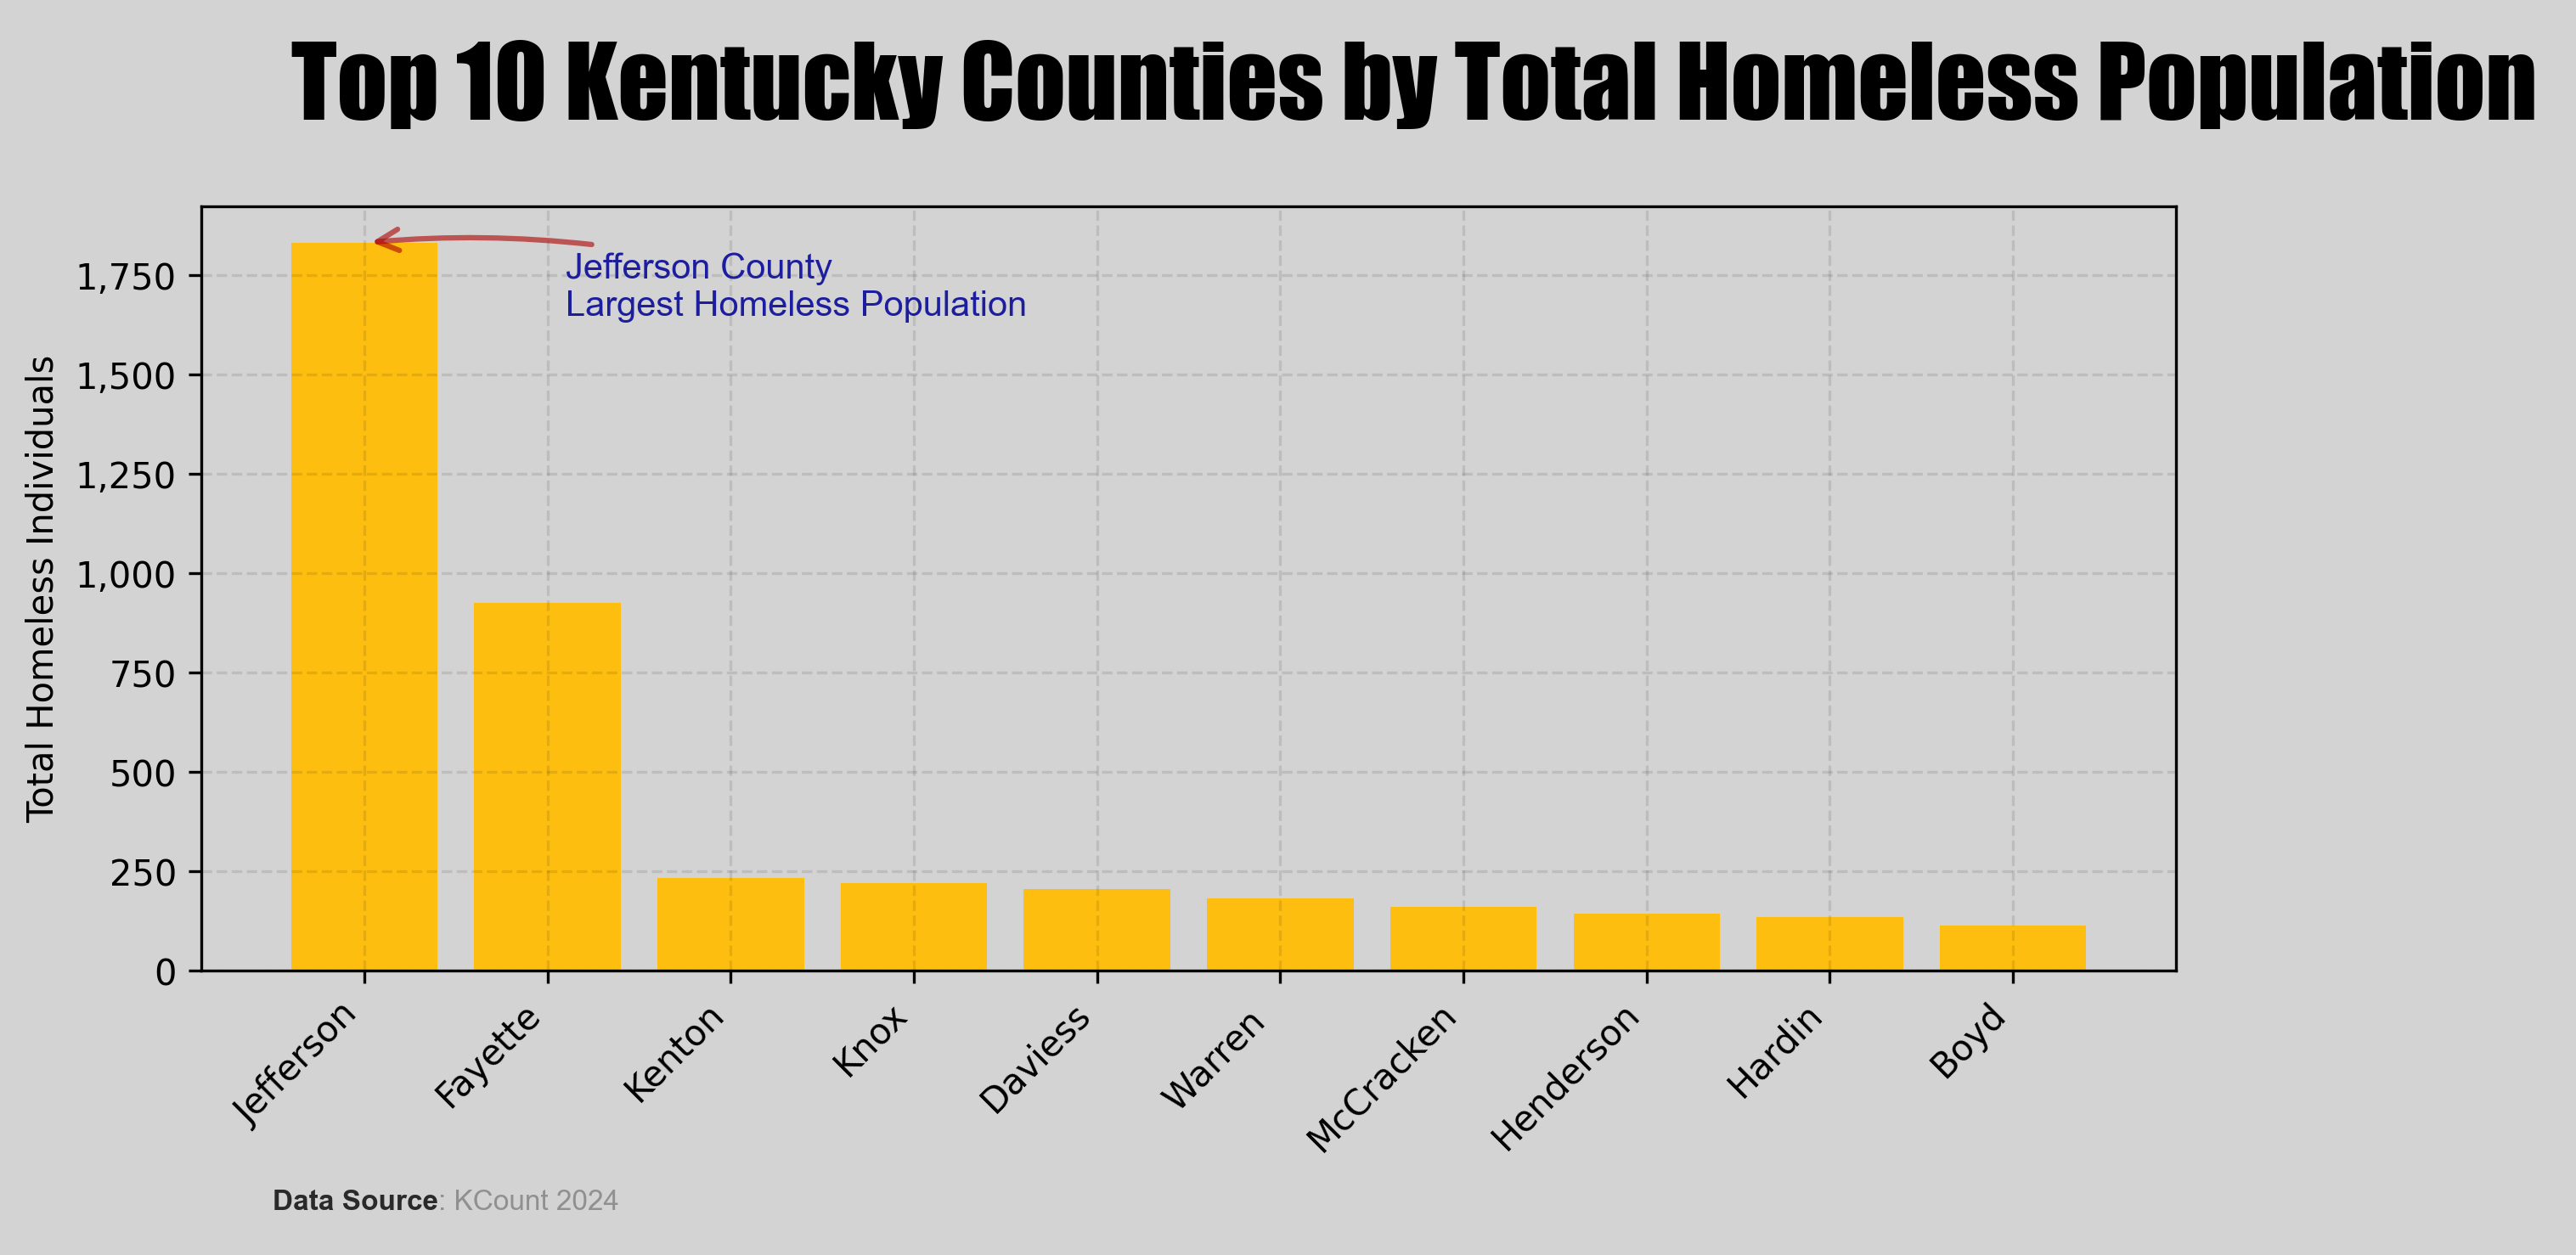

In [64]:
# HUD palette and style
colors = ['#FEBE10', '#1D1E9E', '#AD0000', '#000000', '#FFFFFF']
plt.rcParams.update({
    'axes.prop_cycle': cycler('color', colors),
    'figure.facecolor': 'lightgrey',
    'axes.facecolor': 'lightgrey',
    'axes.grid': True,
    'grid.color': '#000000',
    'grid.alpha': 0.1,
    'grid.linestyle': '--',
    'font.family': 'DejaVu Sans',
    'text.color': '#000000',
    'axes.labelcolor': '#000000',
    'axes.edgecolor': '#000000'
})

# Numeric axis formatter
formatter = mticker.StrMethodFormatter("{x:,.0f}")
def _is_number(s):
    try:
        float(s.replace(',', ''))
        return True
    except ValueError:
        return False
def apply_formatter(ax=None):
    if ax is None:
        ax = plt.gca()
    x_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
    y_labels = [lbl.get_text() for lbl in ax.get_yticklabels()]
    if all(_is_number(lbl) for lbl in x_labels):
        ax.xaxis.set_major_formatter(formatter)
    if all(_is_number(lbl) for lbl in y_labels):
        ax.yaxis.set_major_formatter(formatter)


# --- Data Prep ---
kcount_sorted = (
    kcount_df.sort_values("total_homeless", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# --- Plot ---
plt.figure(figsize=(10, 6), dpi=300)
ax = plt.gca()

plt.bar(kcount_sorted["county"], kcount_sorted["total_homeless"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Homeless Individuals")

# --- Dynamic Title & Subtitle ---
y_max = kcount_sorted["total_homeless"].max()
x_min, x_max = -0.5, len(kcount_sorted["county"]) - 0.5

# Title
s = "Top 10 Kentucky Counties by Total Homeless Population"
ax_text(
    x=x_min + 0.1,
    y=y_max * 1.28,
    s=s,
    fontfamily='impact',
    size=28,
    ha="left"
)

# --- Annotation: Jefferson County (shifted lower and right) ---
jefferson_row = kcount_sorted[kcount_sorted["county"].str.contains("Jefferson", case=False, na=False)]
if not jefferson_row.empty:
    jx = jefferson_row.index[0]
    jy = jefferson_row["total_homeless"].values[0]
    ax.annotate(
        "Jefferson County\nLargest Homeless Population",
        xy=(jx, jy),
        xytext=(jx + 1.1, jy * 0.90),  # lowered position and slight right shift
        ha="left",
        fontsize=10,
        fontfamily='Arial',
        color="#1D1E9E",
        arrowprops=dict(
            arrowstyle="->",
            color="#AD0000",
            lw=1.5,
            mutation_scale=15,
            connectionstyle="arc3,rad=0.1",
            alpha=0.6,
        ),
    )

# --- Caption (kept low under x-ticks) ---
s = "<Data Source>: KCount 2024"
ax_text(
    x=-0.5,
    y=-y_max * 0.30,
    s=s,
    fontfamily='Arial',
    size=8,
    color='grey',
    ha="left",
    alpha=0.8,
    highlight_textprops=[
        {"weight": "bold", "color": "black"}
    ]
)

# --- Formatting ---
apply_formatter()
plt.subplots_adjust(top=0.78, bottom=0.28)

plt.savefig("../ashley/plots/top10_homeless_counties.png", dpi=300, bbox_inches="tight", facecolor=plt.gcf().get_facecolor())
plt.show()

## Subgroups Within the Homeless Population

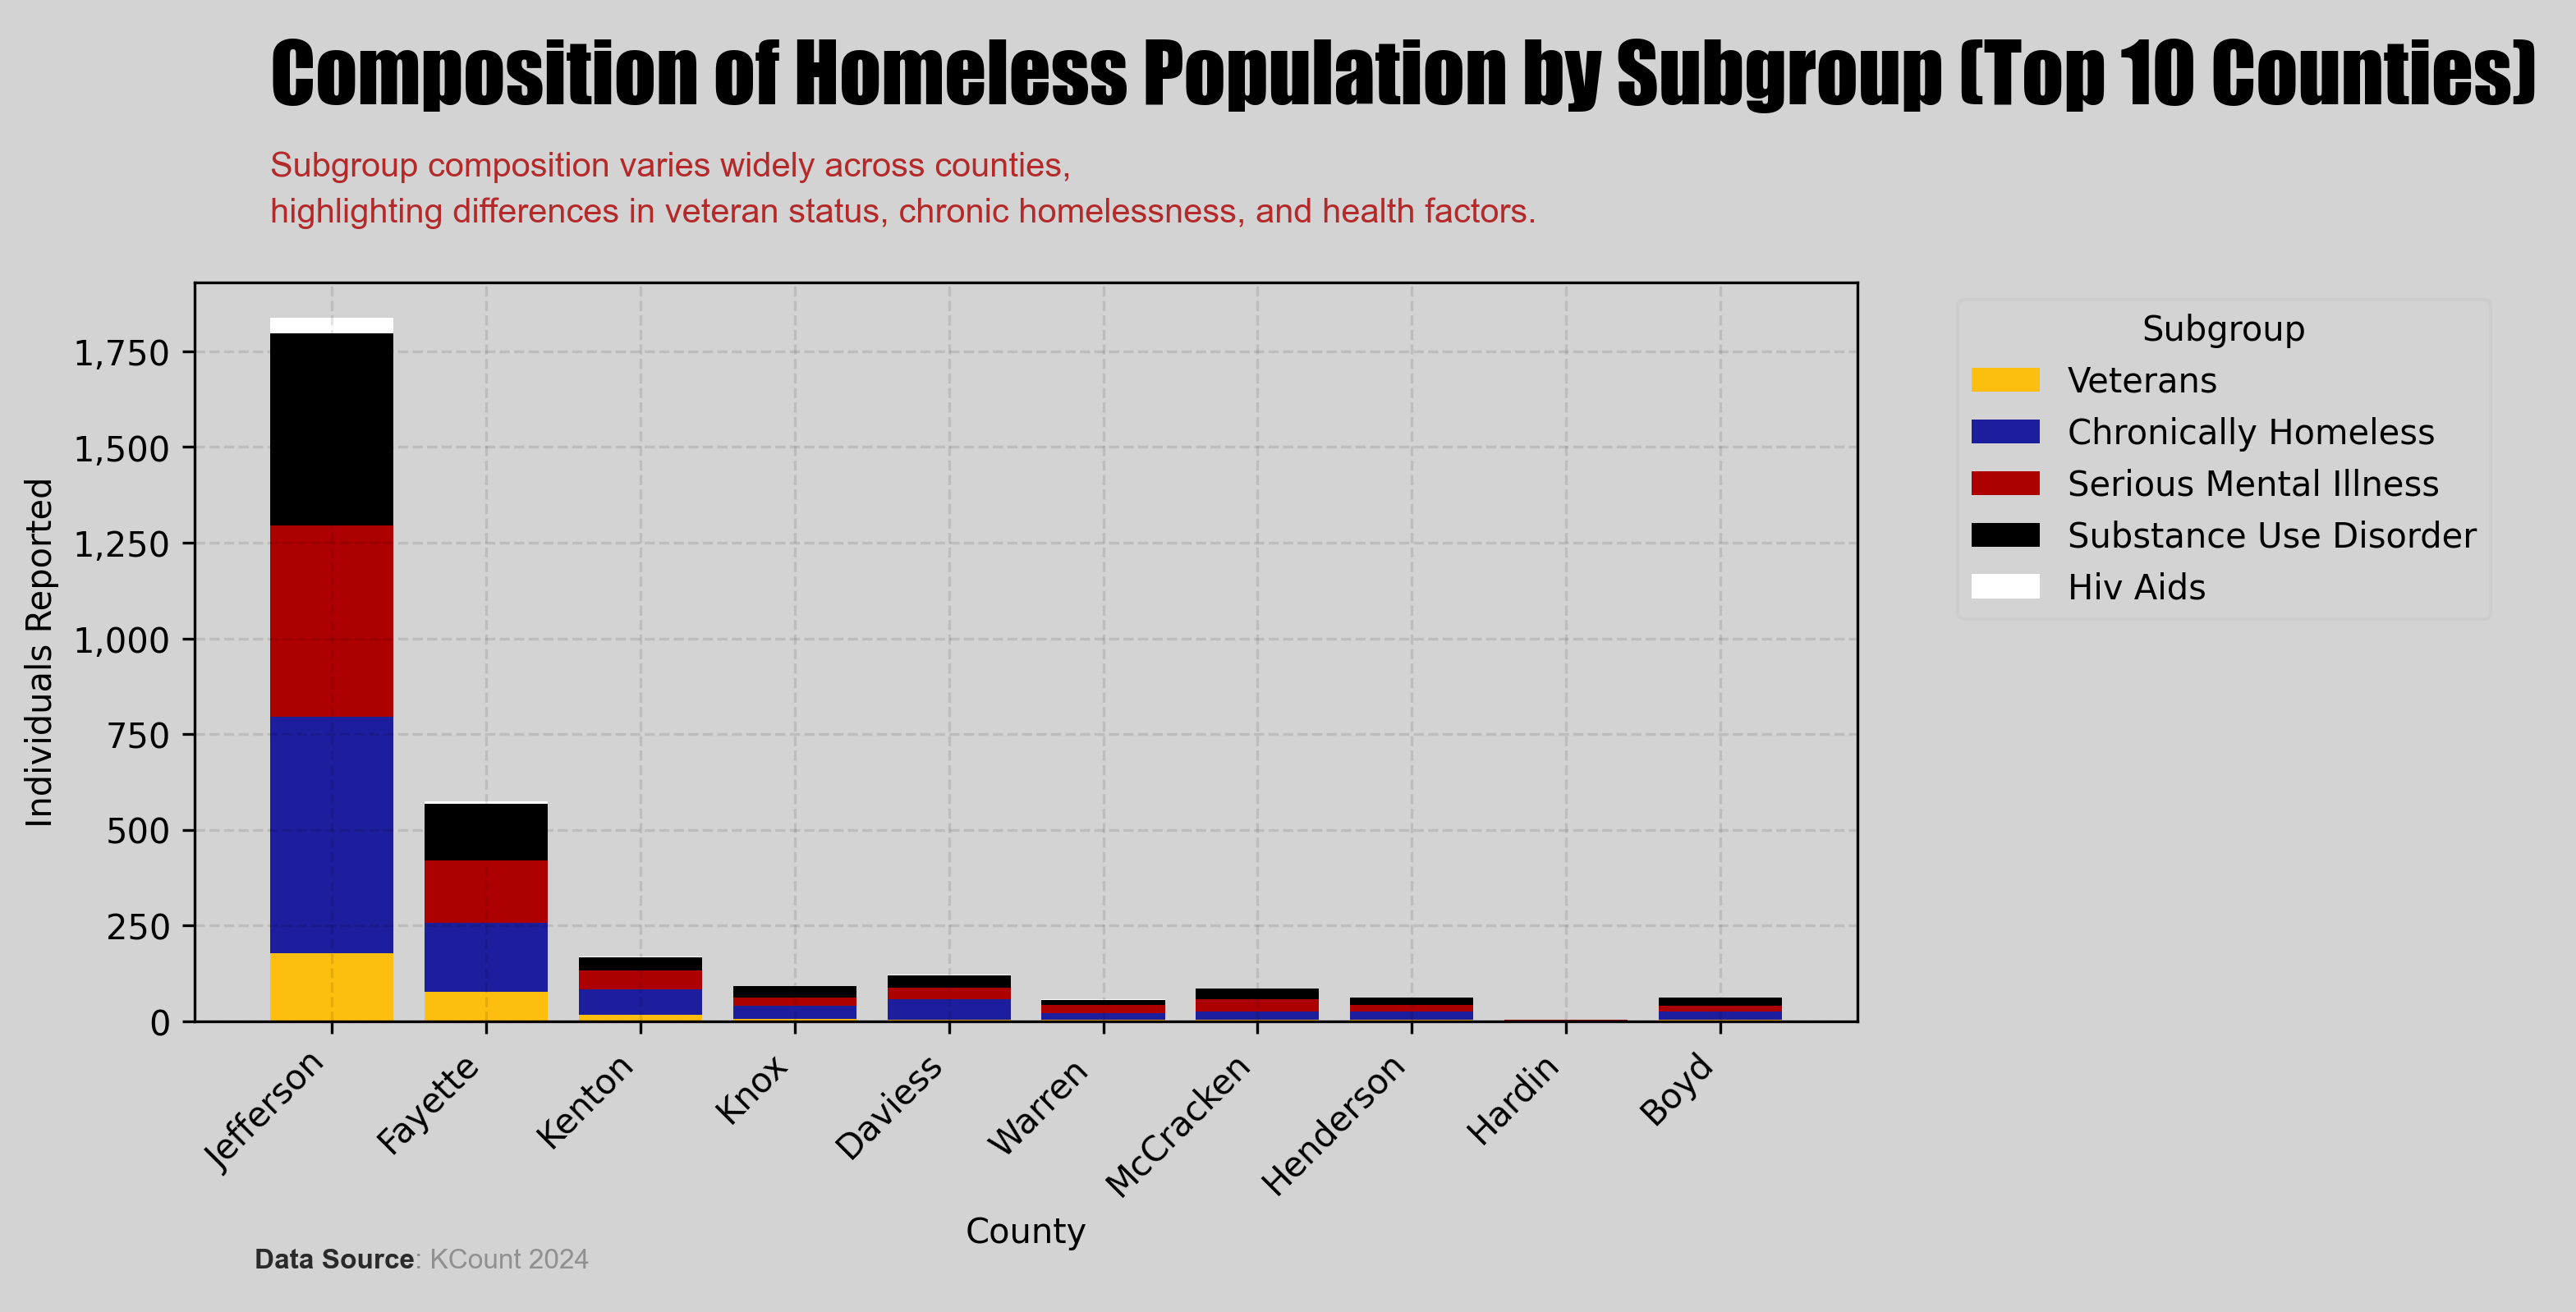

In [65]:
# --- Data prep for subgroup composition plot ---

# Select key subgroup columns (use totals, not rates)
sub_cols = [
    "veterans",
    "chronically_homeless",
    "serious_mental_illness",
    "substance_use_disorder",
    "hiv_aids",
    "domestic_violence"
]

# Get the same Top 10 counties by total homelessness
kcount_top10 = (
    kcount_df.sort_values("total_homeless", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Subset and melt for stacked plotting
subgroup_df = kcount_top10.melt(
    id_vars=["county", "total_homeless"],
    value_vars=sub_cols,
    var_name="subgroup",
    value_name="count"
)

# --- Plot setup ---
plt.figure(figsize=(10, 6), dpi=300)
ax = plt.gca()

# Stacked bar chart
bottom_vals = np.zeros(len(kcount_top10))
for color, subgroup in zip(colors[:len(sub_cols)], sub_cols):
    values = kcount_top10[subgroup]
    plt.bar(
        kcount_top10["county"],
        values,
        bottom=bottom_vals,
        label=subgroup.replace("_", " ").title(),
        color=color
    )
    bottom_vals += values

plt.xticks(rotation=45, ha='right')
plt.ylabel("Individuals Reported")
plt.xlabel("County")

# --- Titles ---
y_max = (kcount_top10[sub_cols].sum(axis=1)).max()
x_min = -0.5

# Main title
s = "Composition of Homeless Population by Subgroup (Top 10 Counties)"
ax_text(
    x=x_min + 0.1,
    y=y_max * 1.30,
    s=s,
    fontfamily='impact',
    size=24,
    ha="left"
)

# Subtitle
s = (
    "Subgroup composition varies widely across counties,\n"
    "highlighting differences in veteran status, chronic homelessness, and health factors."
)
ax_text(
    x=x_min + 0.1,
    y=y_max * 1.15,  # slightly below title
    s=s,
    fontfamily='arial',
    size=10,
    ha="left",
    color="#AD0000",
    alpha=0.8
)

# --- Annotation: Jefferson County ---
jefferson_row = kcount_top10[kcount_top10["county"].str.contains("Jefferson", case=False, na=False)]
if not jefferson_row.empty:
    jx = jefferson_row.index[0]
    jy = jefferson_row[sub_cols].sum(axis=1).values[0]
    ax.annotate(
        "Jefferson County\nLargest Overall Count",
        xy=(jx, jy),
        xytext=(jx + 0.8, jy * 0.8),
        ha="left",
        fontsize=10,
        fontfamily='Arial',
        color="#1D1E9E",
        arrowprops=dict(
            arrowstyle="->",
            color="#AD0000",
            lw=1.5,
            mutation_scale=15,
            connectionstyle="arc3,rad=0.1",
            alpha=0.6,
        ),
    )

# --- Caption ---
s = "<Data Source>: KCount 2024"
ax_text(
    x=-0.5,
    y=-y_max * 0.30,
    s=s,
    fontfamily='Arial',
    size=8,
    color='grey',
    ha="left",
    alpha=0.8,
    highlight_textprops=[
        {"weight": "bold", "color": "black"}
    ]
)

# --- Formatting ---
plt.legend(title="Subgroup", bbox_to_anchor=(1.05, 1), loc='upper left')
apply_formatter()
plt.subplots_adjust(top=0.78, bottom=0.28, right=0.80)

plt.savefig("../ashley/plots/homeless_subgroups_stackedbar.png", dpi=300, bbox_inches="tight", facecolor=plt.gcf().get_facecolor())
plt.show()



# Keep this file in your project

keep at the bottom of your project

We will go over it later, its a script that will generate a markdown table of contents based on your headings created here in markdown.

In [ ]:
import json
import os


def generate_toc_from_notebook(notebook_path):
    """
    Parses a local .ipynb file and generates Markdown for a Table of Contents.
    """
    if not os.path.isfile(notebook_path):
        print(f"❌ Error: File not found at '{notebook_path}'")
        return

    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    toc_markdown = "### **Table of Contents**\n"
    for cell in notebook.get('cells', []):
        if cell.get('cell_type') == 'markdown':
            for line in cell.get('source', []):
                if line.strip().startswith('#'):
                    level = line.count('#')
                    title = line.strip('#').strip()
                    link = title.lower().replace(' ', '-').strip('-.()')
                    indent = '  ' * (level - 1)
                    toc_markdown += f"{indent}* [{title}](#{link})\n"

    print("\n--- ✅ Copy the Markdown below and paste"
          "it into a new markdown cell ---\n")
    print(toc_markdown)


if __name__ == "__main__":
    # Example usage
    notebook_path = 'ashley.ipynb'  # Replace with your notebook path
    generate_toc_from_notebook(notebook_path)


--- ✅ Copy the Markdown below and pasteit into a new markdown cell ---

### **Table of Contents**
    * [**Table of Contents**](#**table-of-contents**)
* [Error Handling](#error-handling)
* [Exploration and Cleaning](#exploration-and-cleaning)
  * [EDA Function](#eda-function)
  * [K Count](#k-count)
  * [HUD](#hud)
* [Keep this file in your project](#keep-this-file-in-your-project)

